# Clustering

Clustering can help identify common themes in the data and segment the data
according to those themes, allowing researchers to get broad insights and dig
deeper into particular themes. Unlike [classification](classification.ipynb),
where categories are pre-defined by the researcher, clustering automatically
identifies different themes. The themes aren't fixed - they will vary each time
the script is run, especially if the parameters of the algorithm are tweaked.

Here's the approach we take to clustering:

1. Each survey response is converted into a vector "embedding" in a high
   dimensional space (> 1000 dimensions). This vector encapsulates the semantic
   meaning of the text (see [get_embeddings.ipynb](get_embeddings.ipynb)).
2. The data is split into a number of distinct groups using a k-means clustering
   algorithm, which looks at the similarity between the embeddings. The number
   of resulting groups is something we specify at the start in the variable
   `n_clusters`.
3. For each cluster, we take a sample of the raw text survey responses and ask
   GPT4 to summarise the theme of the cluster by identifying what each example
   has in common.


In [26]:
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans
import lib
from IPython.display import display, Markdown

datafile_path = "./data/gambling_feedback_data_with_embeddings.csv"
text_col = "feedback"
num_tokens_col = 'feedback-num_tokens'
embedding_col = "feedback-embedding"
survey_context = "Participants have been shown a gambling management tool from a banking app, which allows blocking transactions related to gambling, and setting a monthly limit on how much money can be spent on gambling."
survey_question_full = "Do you have any other feedback on the design of the gambling management tool?"
min_tokens = 10
treatment_arm = 4
n_clusters = 4

In [27]:
df = pd.read_csv(datafile_path)

# convert string to numpy array
df[embedding_col] = df[embedding_col].apply(literal_eval).apply(np.array)

# remove short answers
df = df[df[num_tokens_col] > min_tokens]

df = df[df['treatment'] == treatment_arm]

matrix = np.vstack(df[embedding_col].values)
matrix.shape

(130, 1536)

## Find the clusters using K-means

Try experimenting with different values of `n_clusters`. A high number will
focus on more specific patterns, whereas a small number will usually focus on
the largest discrepencies in the data. See the
[scikit-learn k-means docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html)
for more information on the other parameters this algorithm takes.


In [28]:
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

/Users/dan/Documents/Repos/bit-qual-research/.conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Visualise the clusters

This is a crude visualisation, projecting 1536 dimensions onto a 2d plane.


/var/folders/4c/5kctcgk55539047v8xy3clj80000gn/T/ipykernel_69619/1259791797.py:17: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/dan/Documents/Repos/bit-qual-research/.conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/4c/5kctcgk55539047v8xy3clj80000gn/T/ipykernel_69619/1259791797.py:18: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

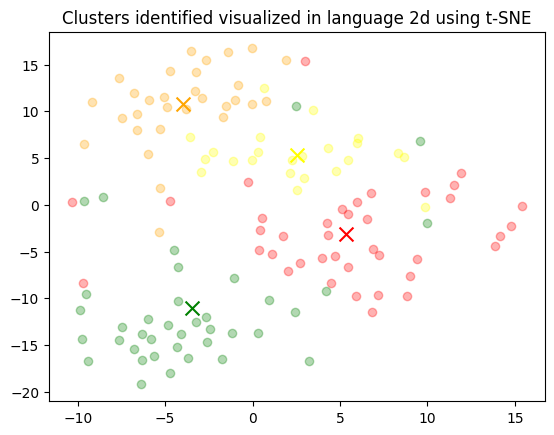

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

rainbow_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'gray', 'brown', 'cyan', 'magenta']

for category, color in enumerate(rainbow_colors):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

## Describe each cluster


In [30]:
subset_size_max = 10

for i in range(n_clusters):
    num_responses = len(df[df.Cluster == i])
    subset =  df[df.Cluster == i].loc[:, text_col].sample(min(subset_size_max, num_responses), random_state=42).values.tolist()
    summary = lib.summarise_answers(survey_context, survey_question_full, subset)
    display(Markdown(f'## Cluster {i+1}: {num_responses} respondents.\n\n ### Theme: **{summary}**\n\n ### Example responses:\n\n{lib.get_answers_string(subset)}\n\n---'))


## Cluster 1: 39 respondents.

 ### Theme: **The common theme in these answers is feedback on the usability and effectiveness of the gambling management tool, with suggestions for improving the design, setting mechanisms, and delay periods to enhance user control and prevent impulsive gambling behavior.**

 ### Example responses:

- "i struggled in trying to change the spending limit from £ 30 to £80. think i have locked my ability to do this for 48 hours."
- "i like the ide of 48 hrs delay to make changes."
- "no but maybe you should have a time block on it"
- "make it more than 48 hours because i can just turn it off and be fine in 2 days but for a week it’s more serious"
- "i think is perfect but their should be an option for one to reset the limit"
- "having a tick box for a complete block alongside the limit might be more intuitive than what feels like separate block / limit settings. if not fully paying attention it is currently very easy to apply a complete block without noticing the limit function."
- "the ‘set limit of £80’ task showed that the set up was not intuitive. pressing the ‘set limit’ button took you away from the page and closed the action. i assume the page was set up so that the amount has to be set up first then the set limit button."
- "simple enough but people will still be able to go to a bank and withdraw over the counter before setting limits"
- "seems like a good idea for most people but obviously across multiply accounts  i could still set each account to a limit"
- "i love the way you guys set a budget it make people know what they are doing"

---

## Cluster 2: 30 respondents.

 ### Theme: **The common theme is skepticism about the effectiveness of the gambling management tool in preventing or reducing problematic gambling behavior, with recognition that it could be a helpful feature for some users but may not deter those determined to gamble.**

 ### Example responses:

- "good idea but not sure it wud make any difference"
- "no, it was ideal for those with a gambling problem.  i definitely haven't"
- "it wouldn't work for me as i rarely do online lottery"
- "i find the opportunity to be able to protect myself from spending all my money a very appealing and sensible idea."
- "i think it seems like a good idea but having a gambling problem myself i don't feel it would discourage people from spending more than they can afford"
- "its a great ide3a for people who can't control their gambling"
- "i haven’t added any money to my ladbrokes account in the last 5 years and i use it regularly , my bet amount is 10p per bet and i’m doing quite well with it"
- "i think it would make people aware of their actions and financial position"
- "it's a good idea, but you can still get cash out to gamble. so there are always ways round it"
- "i'd like to think this would be useful, but if people really want to gamble i don't think this would stop them"

---

## Cluster 3: 23 respondents.

 ### Theme: **The common theme is that while the gambling management tool is generally seen as intuitive and helpful, there are concerns about the ease with which limits can be changed or blocks can be removed, particularly for gambling addicts who might need stricter controls to manage their behavior effectively. Users suggest longer cooling-off periods and more secure settings to prevent impulsive changes to limits or blocks.**

 ### Example responses:

- "quite intuitive layout, the downside is if i was an addict i might want to set an unrealistic limit or disable the feature"
- "when someone mistakenly activates gambling block and decides to change their mind and set a limit instead, the waiting time on using the block should only be activated after pressing the block twice"
- "the gambling block is good but it can easily be turned off"
- "it wouldn’t really help a gambling addict as the block is to easy to remove after 48hrs"
- "the app includes a set of helpful, easy to use tools , and a user can better control his or her gambling behaviour by adjusting different account management settings"
- "a separate switch for setting gambling limit away from all other instructions would be clearer"
- "48hr limit needs to be longer 14 day would be better for gambling addicts"
- "i pressed to set a gambling limit but it was set at the default (30) and i was unable to change this. it was not clear to me how to change the limit"
- "good idea - may slow down problem gamblers slightly - give them a chance to ""cool off"". but since it's auto-enrolment - don't think it would help in all cases. like the design of the page and the 2 day freeze fascility."
- "gambling limit lock should be harder to alter once set"

---

## Cluster 4: 38 respondents.

 ### Theme: **The common theme in these answers is that the gambling management tool is generally perceived as easy to use and beneficial, but there are suggestions for improvements such as updating the design to be more modern, including a dark mode, and ensuring secure login/logout processes.**

 ### Example responses:

- "i think it should be more modern and also have a dark mode"
- "it was a bit bland but i guess it was barebones for the survey"
- "it is easy to use once you have played around with it to get a feel as to its functions."
- "no, it's simple to use and looks great."
- "it’s a clever bit of kit and will save a lot of people"
- "it was very simple to use and great at being a simple solution."
- "easy to use. straight forward.would benefit alot of people."
- "make it easy for users to log in and log out securely"
- "it was very quick and easy to do which may encourage me to use it"
- "it would be a good tool to add to the banking app."

---